In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import wandb
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torchmetrics.classification import MultilabelAccuracy
import copy
import joblib
import shutil
import shap
import seaborn as sns

# User defined libraries
from utils.custom_utils import set_global_random_seed
from utils.dataset_utils import create_preprocessed_datasets
# from inputs_3scale_perov_data import nn_inputs, dataset_inputs, train_inputs
from inputs_syn_data.dataset_inputs import list_of_nn_datasets_dict
from inputs_syn_data.nn_inputs import list_of_nn_params_dict
from inputs_syn_data.train_inputs import list_of_nn_train_params_dict

seed = 0
set_global_random_seed(seed)

# Plotting parameters
fig_aspect_ratio = 1/1.3
# Font style
plt.rcParams.update({
"text.usetex":True,
"font.family":"serif",
"font.serif":["Computer Modern Roman"]})
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1


Global seed set to 0


In [ ]:
import networkx as nx

plt.rcParams['text.usetex'] = True

# Create a Directed Graph
G = nx.DiGraph()

z_labels = ['$z_1$', '$z_2$', '$z_3$', '$z_4$', '$z_5$', '$z_6$', '$z_7$', '$z_8$']
f1_labels = ['$f_1$', '$f_2$', '$f_3$', '$f_4$']

for z in z_labels:
    for f in f1_labels:
        G.add_edge(z, f)

G.add_edge('$f_1$', '$f_5$')
G.add_edge('$f_2$', '$f_5$')
G.add_edge('$f_3$', '$f_5$')
G.add_edge('$f_4$', '$f_5$')

# Create a layout for our nodes 
pos = {'$z_1$': (1, 1), '$z_2$': (1, 2), '$z_3$': (1, 3), '$z_4$': (1, 4), 
       '$z_5$': (1, 5), '$z_6$': (1, 6), '$z_7$': (1, 7), '$z_8$': (1, 8),
       '$f_1$': (2, 1.5), '$f_2$': (2, 3.5), '$f_3$': (2, 5.5), '$f_4$': (2, 7.5),
       '$f_5$': (3, 4.5)}

# Draw the graph using the layout
nx.draw(G, pos, with_labels=True, arrowsize=15, node_size=1000, font_size=20, node_color='skyblue', font_color='black', font_weight='bold')

plt.subplots_adjust(left=0, right=2, top=2, bottom=0)
# Save the plot to pdf 
plt.savefig('multiscale_graph.pdf', dpi=300, bbox_inches='tight', )

# Show the plot
plt.show()

## Model Interpretability

### Plotting model performance vs latent dimension

In [ ]:
# TODO : Store the below loss values in .npy arrays and move them to the model directory

# For RL paper
# # Grid data - UnsupervisedSimpleAE 1
# latent_space = [1, 2, 4, 6, 8]
# total_val_loss = [0.001025053068588022, 0.001063714546035044, 0.0011066086881328374, 0.0013437549932859838, 0.0009386805177200586]
# total_train_loss = [0.007932848995551467, 0.008279352798126638, 0.004237618821207434, 0.004374776501208544, 0.004906855116132647]

# # Grid data - Nonlinf5 SupervisedSimpleAE 2
# latent_space = [1, 2, 4, 6]
# total_val_loss = [0.7463283464312553, 0.2002287097275257, 0.1977713629603386, 0.1788929458707571]
# total_train_loss = [0.4705591835081578, 0.14468571869656444, 0.1250611103605479, 0.13816878804937005]

# # Grid data - Sumf5 - SupervisedSimpleAE 2
# latent_space = [1, 2, 4, 6]
# total_val_loss = [0.49156802892684937, 0.019491535145789385, 0.02250012196600437, 0.02030603913590312]
# total_train_loss = [0.4140172880142927, 0.03587072214577347, 0.02835194836370647, 0.03037486143875867]

# # Random data - UnsupervisedSimpleAE 1
# latent_space = [2, 4, 6, 8]
# total_val_loss = [0.6480237692594528, 0.4781555384397506, 0.24337586015462875, 0.002268550335429609]
# total_train_loss = [0.6661303304135799, 0.4441600125283003, 0.20833437889814377, 0.007954166503623128]

# # Random data - Nonlinf5 - SupervisedSimpleAE 2
# latent_space = [1, 2, 4, 6, 8, 10, 11, 12]
# total_val_loss = [0.7916551381349564, 0.6637141406536102, 0.5525364577770233, 0.3102440983057022, 0.19166426360607147, 0.051493472419679165, 0.021430929424241185, 0.007555923308245838]
# total_train_loss = [0.7504490427672863, 0.6266670003533363, 0.4413919039070606, 0.30615816451609135, 0.18379461765289307, 0.05851957411505282, 0.028894496499560773, 0.016192137030884624]

# # Random data - Sumf5 - SupervisedSimpleAE 2
# # Will have to change the predictor as only prediction loss is high, reconstruction is good.
# latent_space = [1, 2, 4, 6, 8, 10, 11, 12]
# total_val_loss = [1.4578111469745636, 1.4702374935150146, 1.383190006017685, 1.16259, 0.99866, 0.81431, 0.75846, 0.83324]
# total_train_loss = [1.4289479702711103, 1.2744147181510923, 1.0854754857718945, 0.96673, 0.84347, 0.72946, 0.69708, 0.66834]

# Arun2024 (Input dim = 15 + 4 = 19)
# latent_space =      [2,     4,     6,     8,     10,    12,    14]
# pred_val_loss =     [0.206, 0.178, 0.244, 0.227, 0.148, 0.233, 0.231]
# pred_train_loss =   [0.11,  0.076, 0.082, 0.067, 0.074, 0.071, 0.067]
# recont_val_loss =   [0.561, 0.069, 0.055, 0.050, 0.038, 0.046, 0.056]
# recont_train_loss = [0.234, 0.055, 0.037, 0.038, 0.037, 0.042, 0.039]
# total_val_loss = [0.76786, 0.24755343379718917, 	0.24418, 0.27646, 0.18622, 0.27943, 0.28719]
# total_train_loss = [0.38542, 0.16735203887741917, 	0.15132, 0.13772, 0.14288, 0.14528, 0.13803]

# for 10 this is the best that can be done. Adding more layers or increasing the hidden dim or using non linea act does not work.
# val : 0.7632711380720139
# train : 0.7363427169620991
run_dir = 'results_for_RL_paper'
train_loss_matrix_path = f'../runs/{run_dir}/SupSimpleAE_2_ldim10_randomData_nonlinf5/train_total_loss.npy'
val_loss_matrix_path = f'../runs/{run_dir}/SupSimpleAE_2_ldim10_randomData_nonlinf5/val_total_loss.npy'

train_loss_matrix = np.load(train_loss_matrix_path)
val_loss_matrix = np.load(val_loss_matrix_path)
train_mean_losses = np.mean(train_loss_matrix, axis=0)
train_std_losses = np.std(train_loss_matrix, axis=0)
val_mean_losses = np.mean(val_loss_matrix, axis=0)
val_std_losses = np.std(val_loss_matrix, axis=0)

latent_space_to_sweep = [2, 4, 6, 8, 10, 12]

plt.figure(figsize=(4, 3))

# Plot the latent space vs total validation loss
plt.errorbar(latent_space_to_sweep, train_mean_losses, yerr=train_std_losses, label='train', marker='o', linestyle='-')
plt.errorbar(latent_space_to_sweep, val_mean_losses, yerr=val_std_losses, label='val', marker='o', linestyle='-')
# # Label the mean values on top with red color
# for i, txt in enumerate(val_mean_losses):
#     # plt.annotate(f'{txt:.3f}', (latent_space_to_sweep[i], val_mean_losses[i]), textcoords="offset points", xytext=(0,15), ha='center', color='r')
#     print(f'{latent_space_to_sweep[i]} : Val Std dev. : {val_std_losses[i]}')  
#     print(f'{latent_space_to_sweep[i]} : Val Mean : {val_mean_losses[i]}')
# for i, txt in enumerate(train_mean_losses):
#     # plt.annotate(f'{txt:.3f}', (latent_space_to_sweep[i], train_mean_losses[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='b')
#     print(f'{latent_space_to_sweep[i]} : Train Std dev. : {train_std_losses[i]}')  
#     print(f'{latent_space_to_sweep[i]} : Train Mean : {train_mean_losses[i]}')
# plt.plot(latent_space, total_train_loss, marker='o', linestyle='', label='train')
# plt.plot(latent_space, total_val_loss, marker='o', linestyle='', label='val')
plt.xlabel('Latent space dimension')
plt.xticks(latent_space_to_sweep)
# Set the tick labels
plt.ylabel('Total MAE (Reconst. + Pred.)')
plt.legend()

# Adjust the subplot
plt.tight_layout()

# Save the figure
plt.savefig('latent_space_vs_total_loss.pdf')

#### Save the latents to .csv file

In [ ]:
# Save the latents to .csv file
# z, pred, _, _ = model(torch.cat((torch.from_numpy(X1_final), torch.from_numpy(X2_final)), dim=1))
z, _, _, _, _ = model(torch.concat((torch.from_numpy(X1_final), torch.from_numpy(X2_final), torch.from_numpy(X3_final), torch.from_numpy(X4_final)), dim=1))
latent_filename = f'latents_from_{dataset_name}'

# Data folder paths and file names
dataset_folder_name = 'synthetic_dataset'
dataset_file_name = 'synthetic_data_gridSamples_200_sumf5.csv'
new_dataset_file_name = 'synthetic_data_gridSamples_200_sumf5_with_ae1_latents_concat.csv'
run_folder_name = 'perovskite_multiscale_dataset_v2'
model_folder_name = 'best_SupSimpleAE_1_ldim4_arun2024'
AE_number = '1'

dataset_folder = '../datasets/' + dataset_folder_name
dataset_file = dataset_folder + '/' + dataset_file_name
concatenated_dataset_file = dataset_folder + '/' + new_dataset_file_name

run_folder = '../runs/' + run_dir
latent_file = run_folder + '/' + model_name + '/' + latent_filename + '.csv'

# Save the latents to .csv file
z_df = pd.DataFrame(z.detach().numpy())
# pred_df = pd.DataFrame(pred.detach().numpy())
# Conccaetnate the latents and the predictions
# z_pred_df = pd.concat([z_df, pred_df], axis=1)
# z_pred_df = pd.DataFrame(z.detach().numpy())
z_df.to_csv(latent_file, index=False, header=False) 

# latents = pd.read_csv(latent_file, header=None, skiprows=None)
# data = pd.read_csv(dataset_file)

# for i in range(len(latents.columns)):
#     data['AE'+ AE_number +'_latent_'+str(i)] = latents[i]

# data.to_csv(concatenated_dataset_file, index=False)

In [ ]:
# # Find which 'z'is closest to the 'z' provided below
# z_query = torch.tensor([0.26077228, 3.95919058, 0., 0., 0., 0., 1.19784881, 1.33860231], dtype=torch.float32)
# z_query = z_query.unsqueeze(dim=0)
# z_query = z_query.repeat(z.shape[0], 1)
# dist = torch.nn.PairwiseDistance(p=1)
# distances = dist(z, z_query)
# closest_idx = torch.argmin(distances).item()
# print(torch.min(distances))
# print(f'Closest z to the query z is at index : {closest_idx}')
# print(f'Closest z to the query z is : {z[closest_idx]}')
# print(f'Reconst for query z is : {reconst[closest_idx]}')
# print(f'INvert scaling for reconst : {scaler_X.inverse_transform(reconst[closest_idx].detach().numpy().reshape(1, -1))}')

In [ ]:
input = torch.tensor(X_scaled_np32[1, :], requires_grad=True)
print(input)
baseline = torch.zeros_like(input)
print(baseline)
print(model(baseline))

### Feature Importance

### 1. Using Integrated Gradients

In [ ]:
from captum.attr import IntegratedGradients, DeepLift, InputXGradient, Saliency
import seaborn as sns


def model_wrapper(input):
    z, pred, reconst = model(input)
    # z, pred, reconst1, reconst2 = model(input)
    # z, recon1, recon2, recon3, recon4 = model(input)
    return pred

# Create an instance of the IntegratedGradients class
sal = Saliency(model_wrapper)
ig = IntegratedGradients(model_wrapper)
ixg = InputXGradient(model_wrapper)
dl = DeepLift(model_wrapper)

input = torch.from_numpy(X1_final)
# input = torch.cat((torch.from_numpy(X1_scaled_np32), torch.from_numpy(X2_np32)), dim=1)
# input = torch.concat((torch.from_numpy(X1_final), torch.from_numpy(X2_final), torch.from_numpy(X3_final), torch.from_numpy(X4_final)), dim=1)

# attr_sal = sal.attribute(input, target=None)
# attr_sal_np = attr_sal.detach().numpy()
# attr_ixg = ig.attribute(input, baselines=0, target=None)
# attr_ixg_np = attr_ixg.detach().numpy()
attr_ig = ig.attribute(input, baselines=0, target=None)
attr_ig_np = attr_ig.detach().numpy()
# attr_dl = dl.attribute(input, baselines=0, target=None)
# attr_dl_np = attr_dl.detach().numpy()

fig, ax = plt.subplots(figsize=(8, 5))
# # Plot the attributions
using_boxplot = True
if using_boxplot:
    # Label the means on top of the bar in the boxplot
    for i in range(attr_ig_np.shape[1]):
        # plt.text(i+1, 1.5, '{:0.1f}'.format(np.mean(attr_ig_np[:, i])), ha='center', va='bottom')
        # Plot the standard deviation
        plt.text(i+1, 1.6, '{:0.1f}'.format(np.std(attr_ig_np[:, i])), ha='center', va='bottom')
    # Plot the means and standard deviations of the attributions for each feature
    plt.boxplot(attr_ig_np, showmeans=True, meanline=True)
    ax.set_xticklabels(descriptors1, rotation=90)
    plt.title('Integrated Gradients calc. wrt pred')
    plt.show()
else:
    means = np.mean(attr_ig_np, axis=0)
    std_dev = np.std(attr_ig_np, axis=0)
    num_feats = attr_ig_np.shape[1]
    # ax.bar(np.arange(num_feats), means, yerr=std_dev, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.scatter(np.arange(num_feats), means, label='mean', color='r', marker='.')
    ax.errorbar(np.arange(num_feats), means, yerr=std_dev, fmt='o', capsize=5)
    for i in range(attr_ig_np.shape[1]):
        # plt.text(i+1, 1.5, '{:0.1f}'.format(np.mean(attr_ig_np[:, i])), ha='center', va='bottom')
        # Plot the standard deviation
        plt.text(i, 0.8, '{:0.1f}'.format(np.std(attr_ig_np[:, i])), ha='center', va='bottom')
    ax.set_xticks(np.arange(num_feats))
    # descriptors = ['DMF', 'DMF; DMSO', 'DMSO', 'DMSO; GBL', 
    #                '1', '1; 1', '1; 4', '2; 1', '3; 1', '3; 7', '4; 1', '7; 3',
    #                '8; 1', '9; 1', 'Anisole', 'Chlorobenzene', 'Diethyl ether', 
    #                'Ethyl acetate', 'N2', 'Toluene', 
    #                'AE1_latent_0', 'AE1_latent_1', 'AE1_latent_2', 'AE1_latent_3']
    descriptors = ['PET | ITO', 'SLG | FTO', 'SLG | ITO', 
                   'NiO-c', 'PEDOT:PSS', 'PTAA', 'Spiro-MeOTAD',
                   'C60 | BCP', 'PCBM-60', 'PCBM-60 | BCP', 'PCBM-60 | ZnO-np',
                   'SnO2-c', 'SnO2-np', 'TiO2-c', 'TiO2-c | TiO2-mp',
                   'AE2_latent_0', 'AE2_latent_1', 'AE2_latent_2', 'AE2_latent_3',
                   'AE2_latent_4', 'AE2_latent_5', 'AE2_latent_6', 'AE2_latent_7']
    ax.set_xticklabels(descriptors, rotation=90)
    plt.tight_layout()
    plt.show() 

# # Matrix Plot model weights
# for name, param in model.encoder.named_parameters():
#     if name == 'layers.0.weight':
#         ax = plt.figure(figsize=(9, 8))
#         ax = sns.heatmap(param.detach().numpy(), annot=True, fmt='.3f', cmap='coolwarm')
#         # Remove y axis labels
#         ax.yticks([])
#         ax.set_title('Encoder Layer 1 Weights')
    

### 2. Pearson Correlation Coeffs

In [ ]:
def model_wrapper(input):
    z, pred, reconst = model(input)
    # z, pred, reconst1, reconst2 = model(input)
    # z, recon1, recon2, recon3, recon4 = model(input)
    return pred


pred = model_wrapper(torch.from_numpy(X1_final))
corrcoefs = np.corrcoef(X1_final, y=pred.detach().numpy(), rowvar=False)

# In the corr coefs change all values that lie between +- threhold to 0
threshold = 0.1
corrcoefs[np.abs(corrcoefs) < threshold] = 0

# Make a color bar with 0 value as dark gray
# cmap = sns.diverging_palette(220, 20, as_cmap=True)
# cmap.set_bad(color='black')
import matplotlib.colors as colors
cmap = colors.LinearSegmentedColormap.from_list('mycmap', ['blue', 'gray', 'red'])
norm = colors.Normalize(vmin=-1, vmax=1)

# Matrix plot of corr coefs 
# plt.figure(figsize=(12,10))
# Set figure size in inches
plt.figure(figsize=(5, 3.85))

sns.heatmap(corrcoefs, annot=False, cmap=cmap, norm=norm, fmt='.2f', annot_kws={"color": 'black', 'size':1})
plt.tick_params(axis='x', labelbottom=False, labeltop=True)

plt.gca().xaxis.tick_top()

plt.xticks(np.arange(X1_final.shape[1] + 1) + 0.5, labels=descriptors1 + ['f5_pred'], rotation=90)
plt.yticks(np.arange(X1_final.shape[1] + 1) + 0.5, labels=descriptors1 + ['f5_pred'], rotation=0)

#Adjust subplot size
plt.tight_layout()

# Save the plot to pdf
plt.savefig('corr_coefs.pdf')

### 3. Using SHAP

In [2]:
from nn.vanilla_ae import VanillaAE
import yaml
from utils.custom_utils import read_from_pickle

# Loading the singleAE and nestedAE models
singleAE_dir = '../runs/perovskite_multiscale_dataset_3/singleAE_fold0/tune_nn_params/eager-sweep-13_fold_0'
nestedAE_AE2_dir = '../runs/perovskite_multiscale_dataset_3/corrected_nestedAE_AE2_fold0/tune_nn_params/swept-sweep-30_fold_0'
nestedAE_AE1_dir = '../runs/perovskite_multiscale_dataset_3/ae1_fold0'

# Read the nn_params_dict, nn_train_params_dict and nn_datasets_dict from the config.yaml file
singleAE_nn_save_dir = yaml.safe_load(open(singleAE_dir + '/files/config.yaml'))['nn_save_dir']['value']
singleAE_nn_params_dict = yaml.safe_load(open(singleAE_dir + '/files/config.yaml'))['nn_params_dict']['value']
singleAE_nn_train_params_dict = yaml.safe_load(open(singleAE_dir + '/files/config.yaml'))['nn_train_params_dict']['value']
singleAE_nn_datasets_dict = yaml.safe_load(open(singleAE_dir + '/files/config.yaml'))['nn_datasets_dict']['value']

nestedAE_AE2_nn_save_dir = yaml.safe_load(open(nestedAE_AE2_dir + '/files/config.yaml'))['nn_save_dir']['value']
nestedAE_AE2_nn_params_dict = yaml.safe_load(open(nestedAE_AE2_dir + '/files/config.yaml'))['nn_params_dict']['value']
nestedAE_AE2_nn_train_params_dict = yaml.safe_load(open(nestedAE_AE2_dir + '/files/config.yaml'))['nn_train_params_dict']['value']
nestedAE_AE2_nn_datasets_dict = yaml.safe_load(open(nestedAE_AE2_dir + '/files/config.yaml'))['nn_datasets_dict']['value']

nestedAE_AE1_nn_params_dict = read_from_pickle('list_of_nn_params_dict.pkl', nestedAE_AE1_dir)[0]
nestedAE_AE1_nn_train_params_dict = read_from_pickle('list_of_nn_train_params_dict.pkl', nestedAE_AE1_dir)[0]
nestedAE_AE1_nn_datasets_dict = read_from_pickle('list_of_nn_datasets_dict.pkl', nestedAE_AE1_dir)[0]

new_singleAE = VanillaAE(singleAE_nn_save_dir, singleAE_nn_params_dict, singleAE_nn_train_params_dict, singleAE_nn_datasets_dict)
new_nestedAE_AE2 = VanillaAE(nestedAE_AE2_nn_save_dir, nestedAE_AE2_nn_params_dict, nestedAE_AE2_nn_train_params_dict, nestedAE_AE2_nn_datasets_dict)
new_nestedAE_AE1 = VanillaAE(nestedAE_AE1_dir, nestedAE_AE1_nn_params_dict, nestedAE_AE1_nn_train_params_dict, nestedAE_AE1_nn_datasets_dict)

# Copy the file to current directory 
os.mkdir('singleAE_copied_ckpt')
shutil.copy(singleAE_dir + '/checkpoints/last.ckpt', 'singleAE_copied_ckpt')
os.mkdir('nestedAE_AE2_copied_ckpt')
shutil.copy(nestedAE_AE2_dir + '/checkpoints/last.ckpt', 'nestedAE_AE2_copied_ckpt')
os.mkdir('nestedAE_AE1_copied_ckpt')
shutil.copy(nestedAE_AE1_dir + '/checkpoints/last.ckpt', 'nestedAE_AE1_copied_ckpt')
loaded_singleAE = new_singleAE.load_from_checkpoint('singleAE_copied_ckpt/last.ckpt')
loaded_nestedAE_AE2 = new_nestedAE_AE2.load_from_checkpoint('nestedAE_AE2_copied_ckpt/last.ckpt')
loaded_nestedAE_AE1 = new_nestedAE_AE1.load_from_checkpoint('nestedAE_AE1_copied_ckpt/last.ckpt')
# Delete the created directories
shutil.rmtree('singleAE_copied_ckpt')
shutil.rmtree('nestedAE_AE2_copied_ckpt')
shutil.rmtree('nestedAE_AE1_copied_ckpt')



 --> Submodule encoder layers :
ModuleList(
  (0): Linear(in_features=26, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=12, bias=True)
  (3): ReLU()
)


 --> Submodule bg_pred layers :
ModuleList(
  (0): Linear(in_features=12, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
  (3): ReLU()
)


 --> Submodule all_props_pred layers :
ModuleList(
  (0): Linear(in_features=12, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=15, bias=True)
)


 --> Submodule etm_pred layers :
ModuleList(
  (0): Linear(in_features=12, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=7, bias=True)
)


 --> Submodule htm_pred layers :
ModuleList(
  (0): Linear(in_features=12, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=4, bias=True)
)


 --> Submodule encoder layers :
ModuleList(
  (0): Linear(in_features=23, 

In [ ]:
from nn.vanilla_ae import VanillaAE
import yaml
from utils.custom_utils import read_from_pickle

nestedAE_AE2_targetf5_dir = '../runs/results_for_RL_paper/nestedAE_AE2_targetf5_fold0/tune_nn_params/jolly-sweep-4_fold_0'
nestedAE_AE2_targetf6_dir = '../runs/results_for_RL_paper/nestedAE_AE2_targetf6_fold0/tune_nn_params/chocolate-sweep-40_fold_0'

# Read the nn_params_dict, nn_train_params_dict and nn_datasets_dict from the config.yaml file
nestedAE_AE2_targetf5_nn_save_dir = yaml.safe_load(open(nestedAE_AE2_targetf5_dir + '/files/config.yaml'))['nn_save_dir']['value']
nestedAE_AE2_targetf5_nn_params_dict = yaml.safe_load(open(nestedAE_AE2_targetf5_dir + '/files/config.yaml'))['nn_params_dict']['value']
nestedAE_AE2_targetf5_nn_train_params_dict = yaml.safe_load(open(nestedAE_AE2_targetf5_dir + '/files/config.yaml'))['nn_train_params_dict']['value']
nestedAE_AE2_targetf5_nn_datasets_dict = yaml.safe_load(open(nestedAE_AE2_targetf5_dir + '/files/config.yaml'))['nn_datasets_dict']['value']

nestedAE_AE2_targetf6_nn_save_dir = yaml.safe_load(open(nestedAE_AE2_targetf6_dir + '/files/config.yaml'))['nn_save_dir']['value']
nestedAE_AE2_targetf6_nn_params_dict = yaml.safe_load(open(nestedAE_AE2_targetf6_dir + '/files/config.yaml'))['nn_params_dict']['value']
nestedAE_AE2_targetf6_nn_train_params_dict = yaml.safe_load(open(nestedAE_AE2_targetf6_dir + '/files/config.yaml'))['nn_train_params_dict']['value']
nestedAE_AE2_targetf6_nn_datasets_dict = yaml.safe_load(open(nestedAE_AE2_targetf6_dir + '/files/config.yaml'))['nn_datasets_dict']['value']

new_nestedAE_AE2_targetf5 = VanillaAE(nestedAE_AE2_targetf5_nn_save_dir, nestedAE_AE2_targetf5_nn_params_dict, nestedAE_AE2_targetf5_nn_train_params_dict, nestedAE_AE2_targetf5_nn_datasets_dict)
new_nestedAE_AE2_targetf6 = VanillaAE(nestedAE_AE2_targetf6_nn_save_dir, nestedAE_AE2_targetf6_nn_params_dict, nestedAE_AE2_targetf6_nn_train_params_dict, nestedAE_AE2_targetf6_nn_datasets_dict)

os.mkdir('nestedAE_AE2_targetf5_copied_ckpt')
shutil.copy(nestedAE_AE2_targetf5_dir + '/checkpoints/last.ckpt', 'nestedAE_AE2_targetf5_copied_ckpt')
os.mkdir('nestedAE_AE2_targetf6_copied_ckpt')
shutil.copy(nestedAE_AE2_targetf6_dir + '/checkpoints/last.ckpt', 'nestedAE_AE2_targetf6_copied_ckpt')
loaded_nestedAE_AE2_targetf5 = new_nestedAE_AE2_targetf5.load_from_checkpoint('nestedAE_AE2_targetf5_copied_ckpt/last.ckpt')
loaded_nestedAE_AE2_targetf6 = new_nestedAE_AE2_targetf6.load_from_checkpoint('nestedAE_AE2_targetf6_copied_ckpt/last.ckpt')
# Delete the created directories
shutil.rmtree('nestedAE_AE2_targetf5_copied_ckpt')
shutil.rmtree('nestedAE_AE2_targetf6_copied_ckpt')

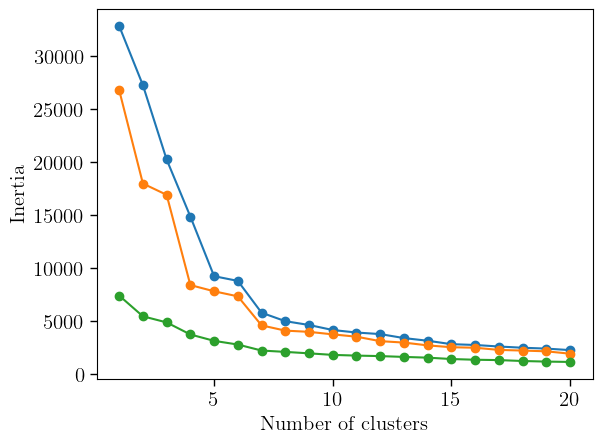

In [3]:
from sklearn.cluster import KMeans

def kmeans_clustering(dataset, num_clusters):
    krange = np.arange(1, num_clusters+1)
    inertia = np.zeros(len(krange))

    for k in krange:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(dataset)
        if k == krange[-1]:
            background_dataset = kmeans.cluster_centers_
            # Change dtypes to np.float32
            background_dataset = background_dataset.astype(np.float32)
        inertia[k-1] = kmeans.inertia_
    
    # Plot elbow plot
    plt.plot(krange, inertia, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    return background_dataset

# For the synthetic dataset
# cols = ['f1', 'f2', 'f3', 'f4', 'AE1_latent_0', 'AE1_latent_1', 'AE1_latent_2', 'AE1_latent_3', 'AE1_latent_4', 'AE1_latent_5', 'AE1_latent_6', 'AE1_latent_7']
# cols_for_plot = [r'$f_1$', r'$f_2$', r'$f_3$', r'$f_4$', r'$l^0_1$', r'$l^1_1$', r'$l^2_1$', r'$l^3_1$', r'$l^4_1$', r'$l^5_1$', r'$l^6_1$', r'$l^7_1$']
# rand_sumf5_dataset = pd.read_csv('../datasets/synthetic_dataset/synthetic_data_randomSamples_200_sumf5_with_ae1_latents_concat.csv', usecols=cols).to_numpy()
# rand_nonlinf5_dataset = pd.read_csv('../datasets/synthetic_dataset/synthetic_data_randomSamples_200_with_ae1_latents_concat.csv', usecols=cols).to_numpy()
# # Standardize the dataset
# scaler = StandardScaler()
# rand_sumf5_dataset_scaled = scaler.fit_transform(rand_sumf5_dataset)
# rand_nonlinf5_dataset_scaled = scaler.fit_transform(rand_nonlinf5_dataset)

# For the perovskite dataset
# cols = ['A_rad', 'A_wt', 'A_EA', 'A_IE', 'A_En', 'B_rad', 'B_wt', 'B_EA', 'B_IE', 'B_En', 'X_rad', 'X_wt', 'X_EA', 'X_IE', 'X_En',
#         r'C60 | BCP', r'PCBM-60', r'PCBM-60 | BCP', r'SnO_2-c', r'SnO_2-np', r'TiO_2-c', r'TiO_2-c | TiO_2-mp',
#         r'NiO-c', r'PEDOT:PSS', r'PTAA', r'Spiro-MeOTAD']
cols_for_singleAE = ['A_ion_rad', 'A_at_wt', 'A_EA', 'A_IE', 'A_En', 'B_ion_rad', 'B_at_wt', 'B_EA', 'B_IE', 'B_En', 'X_ion_rad', 'X_at_wt', 'X_EA', 'X_IE', 'X_En',
                     'C60 | BCP', 'PCBM-60', 'PCBM-60 | BCP', 'SnO2-c', 'SnO2-np', 'TiO2-c', 'TiO2-c | TiO2-mp',
                     'NiO-c', 'PEDOT:PSS', 'PTAA', 'Spiro-MeOTAD']
cols_for_nestedAE_AE2 = ['l_1', 'l_2', 'l_3', 'l_4', 'l_5', 'l_6', 'l_7', 'l_8', 'l_9', 'l_10', 'l_11', 'l_12',
                     'C60 | BCP', 'PCBM-60', 'PCBM-60 | BCP', 'SnO2-c', 'SnO2-np', 'TiO2-c', 'TiO2-c | TiO2-mp',
                     'NiO-c', 'PEDOT:PSS', 'PTAA', 'Spiro-MeOTAD']
cols_for_nestedAE_AE1 = ['A_ion_rad', 'A_at_wt', 'A_EA', 'A_IE', 'A_En', 'B_ion_rad', 'B_at_wt', 'B_EA', 'B_IE', 'B_En', 'X_ion_rad', 'X_at_wt', 'X_EA', 'X_IE', 'X_En']
cols_for_plot_singleAE = ['$A_{\mathrm{rad}}$', '$A_{\mathrm{wt}}$', '$A_{\mathrm{EA}}$', '$A_{\mathrm{IE}}$', '$A_{\mathrm{En}}$', '$B_{\mathrm{rad}}$', '$B_{\mathrm{wt}}$', '$B_{\mathrm{EA}}$', '$B_{\mathrm{IE}}$', '$B_{\mathrm{En}}$', '$X_{\mathrm{rad}}$', '$X_{\mathrm{wt}}$', '$X_{\mathrm{EA}}$', '$X_{\mathrm{IE}}$', '$X_{\mathrm{En}}$',
                          'C60 $|$ BCP', 'PCBM-60', 'PCBM-60 $|$ BCP', 'Sn$O_2$-c', 'Sn$O_2$-np', 'Ti$O_2$-c', 'Ti$O_2$-c $|$ Ti$O_2$-mp',
                          'NiO-c', 'PEDOT:PSS', 'PTAA', 'Spiro-MeOTAD']
cols_for_plot_nestedAE_AE2 = ['$l_{1}^{AE1}$', '$l_{2}^{AE1}$', '$l_{3}^{AE1}$', '$l_{4}^{AE1}$', '$l_{5}^{AE1}$', '$l_{6}^{AE1}$', '$l_{7}^{AE1}$', '$l_{8}^{AE1}$', '$l_{9}^{AE1}$', '$l_{10}^{AE1}$', '$l_{11}^{AE1}$', '$l_{12}^{AE1}$',
                          'C60 $|$ BCP', 'PCBM-60', 'PCBM-60 $|$ BCP', 'Sn$O_2$-c', 'Sn$O_2$-np', 'Ti$O_2$-c', 'Ti$O_2$-c $|$ Ti$O_2$-mp',
                          'NiO-c', 'PEDOT:PSS', 'PTAA', 'Spiro-MeOTAD']
cols_for_plot_nestedAE_AE1 = ['$A_{\mathrm{rad}}$', '$A_{\mathrm{wt}}$', '$A_{\mathrm{EA}}$', '$A_{\mathrm{IE}}$', '$A_{\mathrm{En}}$', '$B_{\mathrm{rad}}$', '$B_{\mathrm{wt}}$', '$B_{\mathrm{EA}}$', '$B_{\mathrm{IE}}$', '$B_{\mathrm{En}}$', '$X_{\mathrm{rad}}$', '$X_{\mathrm{wt}}$', '$X_{\mathrm{EA}}$', '$X_{\mathrm{IE}}$', '$X_{\mathrm{En}}$']
singleAE_dataset = torch.cat((loaded_singleAE.all_samples['all_props'], loaded_singleAE.all_samples['etm'], loaded_singleAE.all_samples['htm']), dim=1).detach().numpy()
nestedAE_AE2_dataset = torch.cat((loaded_nestedAE_AE2.all_samples['latents'], loaded_nestedAE_AE2.all_samples['etm'], loaded_nestedAE_AE2.all_samples['htm']), dim=1).detach().numpy()
nestedAE_AE1_dataset = loaded_nestedAE_AE1.all_samples['all_props'].detach().numpy()
singleAE_background_dataset = kmeans_clustering(singleAE_dataset, 20)
nestedAE_AE2_background_dataset = kmeans_clustering(nestedAE_AE2_dataset, 20)
nestedAE_AE1_background_dataset = kmeans_clustering(nestedAE_AE1_dataset, 20)

In [5]:
# Define model wrappers here to use with SHAP 

def singleAE_model_wrapper(input):
    input_mod = {'all_props': torch.tensor(input[:,:15], requires_grad=True, dtype=torch.float32), 
                 'etm':torch.tensor(input[:,15:22], requires_grad=True, dtype=torch.float32), 
                 'htm':torch.tensor(input[:,22:], requires_grad=True, dtype=torch.float32)}
    submodule_outputs = loaded_singleAE(input_mod)
    return submodule_outputs['bg_pred'].detach().numpy() # Note : This was an error in specifying the name of the submodule. It is actually PCE_pred

def nestedAE_AE2_model_wrapper(input):
    input_mod = {'latents': torch.tensor(input[:,:12], requires_grad=True, dtype=torch.float32),
                    'etm':torch.tensor(input[:,12:19], requires_grad=True, dtype=torch.float32),
                    'htm':torch.tensor(input[:,19:], requires_grad=True, dtype=torch.float32)}
    submodule_outputs = loaded_nestedAE_AE2(input_mod)
    return submodule_outputs['PCE_pred'].detach().numpy()

def nestedAE_AE1_model_wrapper(input):
    input_mod = {'all_props': torch.tensor(input[:,:], requires_grad=True, dtype=torch.float32)}
    submodule_outputs = loaded_nestedAE_AE1(input_mod)
    return submodule_outputs['bg_pred'].detach().numpy()

def nestedAE_AE1_model_wrapper_l1_pred(input):
    input_mod = {'all_props': torch.tensor(input[:,:], requires_grad=True, dtype=torch.float32)}
    submodule_outputs = loaded_nestedAE_AE1(input_mod)
    return submodule_outputs['encoder'][:,0].detach().numpy()

In [9]:

# For the PSC_efficiencies dataset 

# Note : Cannot use exact explainer as num_evals is too high. This is because the fetaure space is too large.
# singleAE_explainer = shap.Explainer(singleAE_model_wrapper, singleAE_background_dataset, algorithm='permutation', output_names='PCE_pred')
# singleAE_explainer_shap = singleAE_explainer(singleAE_background_dataset)
# singleAE_explainer_shap.feature_names = singleAE_dataset_cols
nestedAE_AE2_explainer = shap.Explainer(nestedAE_AE2_model_wrapper, nestedAE_AE2_background_dataset, algorithm='auto', output_names='PCE_pred')
nestedAE_AE2_explainer_shap = nestedAE_AE2_explainer(nestedAE_AE2_dataset)
nestedAE_AE2_explainer_shap.feature_names = cols_for_nestedAE_AE2
# singleAE_explainer = shap.KernelExplainer(singleAE_model_wrapper, data=singleAE_background_dataset, link='identity', feature_names=cols_for_singleAE)
# singleAE_shap_values = singleAE_explainer.shap_values(singleAE_dataset)
# nestedAE_AE2_explainer = shap.KernelExplainer(nestedAE_AE2_model_wrapper, data=nestedAE_AE2_background_dataset, link='identity', feature_names=cols_for_nestedAE_AE2)
# nestedAE_AE2_shap_values = nestedAE_AE2_explainer.shap_values(nestedAE_AE2_dataset)

# Kernel Explainer
# kernel_explainer = shap.KernelExplainer(model_wrapper, data=background_dataset, link='identity', feature_names=cols)
# shap_values = kernel_explainer.shap_values(dataset)
# shap_values = np.squeeze(shap_values, axis=-1)
# shap.initjs()
# shap.summary_plot(shap_values, features=dataset, feature_names=cols, max_display=10, plot_type='dot', show=False, plot_size=(5.8, 3.5))

PermutationExplainer explainer: 2019it [00:25, 50.09it/s]                          


In [ ]:
# nestedAE_AE1_explainer = shap.KernelExplainer(nestedAE_AE1_model_wrapper, data=nestedAE_AE1_background_dataset, link='identity', feature_names=cols_for_nestedAE_AE1)
# nestedAE_AE1_shap_values = nestedAE_AE1_explainer.shap_values(nestedAE_AE1_dataset)
# nestedAE_AE1_explainer_l1_pred = shap.KernelExplainer(nestedAE_AE1_model_wrapper_l1_pred, data=nestedAE_AE1_background_dataset, link='identity', feature_names=cols_for_nestedAE_AE1)
# nestedAE_AE1_shap_values_l1_pred = nestedAE_AE1_explainer_l1_pred.shap_values(nestedAE_AE1_dataset)

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

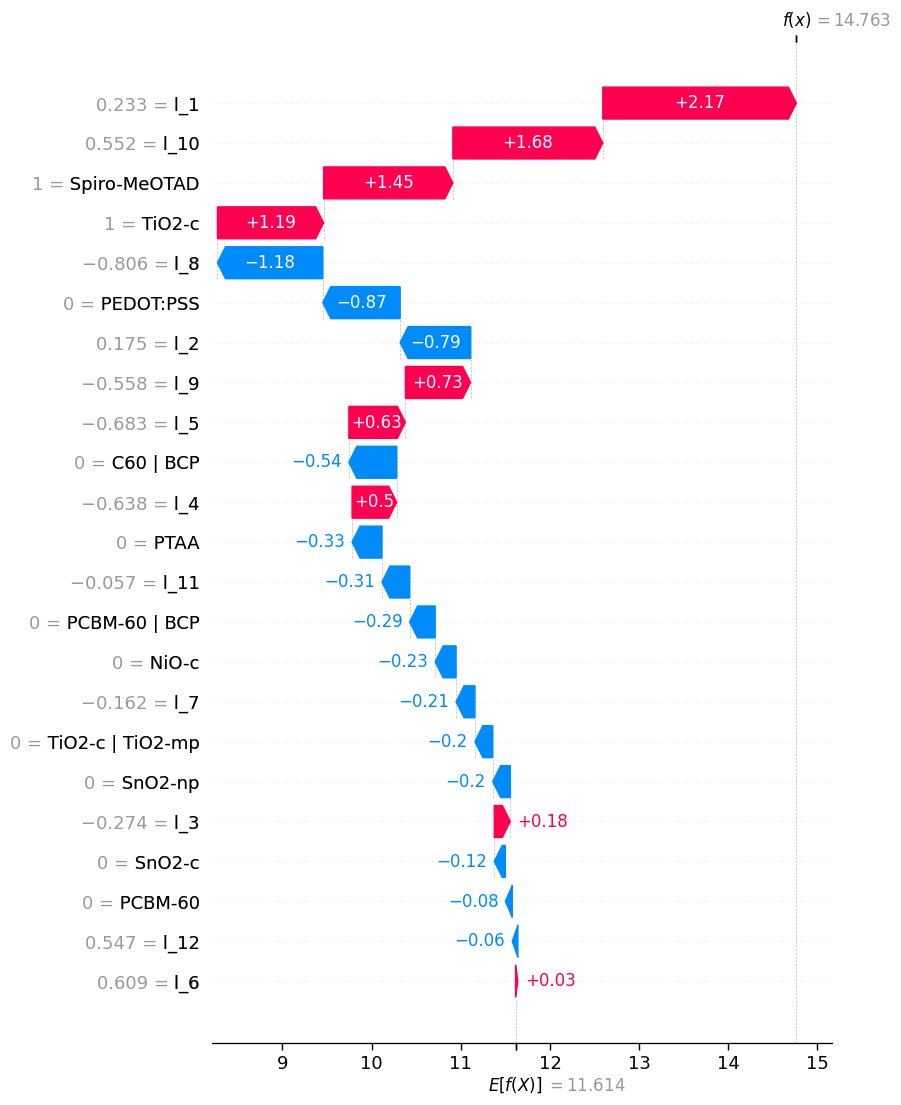

<Figure size 640x480 with 0 Axes>

In [17]:
plt.rcParams['text.usetex'] = False
seed = 0
shap.plots.waterfall(nestedAE_AE2_explainer_shap[seed], max_display=30, show=True)
# shap.waterfall_plot(shap_values_from_explainer[seed], max_display=12, show=True)
# Save SHAP waterfall plot to pdf
plt.savefig('shap_waterfall.pdf', bbox_inches='tight', dpi=300)

In [ ]:
plt.rcParams['text.usetex'] = False
shap.plots.waterfall(rand_sumf5_explainer_shap[seed], max_display=12, show=True)
# shap.waterfall_plot(shap_values_from_explainer[seed], max_display=12, show=True)
# Save SHAP waterfall plot to pdf
plt.savefig('shap_waterfall_random_sumf5.pdf', bbox_inches='tight', dpi=300)

In [ ]:
shap.plots.waterfall(rand_nonlinf5_explainer_shap[seed], max_display=12, show=True)
# shap.waterfall_plot(shap_values_from_explainer[seed], max_display=12, show=True)
# Save SHAP waterfall plot to pdf
plt.savefig('shap_waterfall_random_nonlinf5.pdf', bbox_inches='tight', dpi=300)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.5))

# Calculate the mean SHAP values
# rand_sumf5_mean_shap = np.mean(np.abs(rand_sumf5_explainer_shap.values), axis=0)
# rand_nonlinf5_mean_shap = np.mean(np.abs(rand_nonlinf5_explainer_shap.values), axis=0)
# singleAE_mean_shap = np.mean(np.abs(singleAE_shap_values), axis=0)
# nestedAE_AE2_mean_shap = np.mean(np.abs(nestedAE_AE2_shap_values), axis=0)
# nestedAE_AE1_mean_shap = np.mean(np.abs(nestedAE_AE1_shap_values), axis=0)
# nestedAE_AE1_mean_shap_l1_pred = np.mean(np.abs(nestedAE_AE1_shap_values_l1_pred), axis=0)


# Sort the bars according to the magnitude of the SHAP values
# bars1 = ax1.barh(cols_for_plot, rand_sumf5_mean_shap , capsize=8)
# bars2 = ax2.barh(cols_for_plot, rand_nonlinf5_mean_shap, capsize=8)
# bars1 = ax1.barh(cols_for_plot_singleAE, np.squeeze(singleAE_mean_shap), capsize=8)
# bars2 = ax2.barh(cols_for_plot_nestedAE_AE2, np.squeeze(nestedAE_AE2_mean_shap), capsize=8)
# bars1 = ax1.barh(cols_for_plot_nestedAE_AE1, np.squeeze(nestedAE_AE1_mean_shap), capsize=8)
# bars2 = ax2.barh(cols_for_plot_nestedAE_AE1, np.squeeze(nestedAE_AE1_mean_shap_l1_pred), capsize=8)

# Put a text box underneath the first subplot with label (a)
ax1.text(0.98, 0.98, 'A', transform=ax1.transAxes, va='top', fontsize=12, ha='right')
ax2.text(0.98, 0.98, 'B', transform=ax2.transAxes, va='top', fontsize=12, ha='right')

# Set the X limits of both to 3
# ax1.set_xlim([0, 2.5])
# ax2.set_xlim([0, 2.5])

# Set combined y label for both subplots
ax1.set_ylabel('Features')
ax1.set_xlabel('Mean ($| \mathrm{SHAP} |$)')
ax2.set_xlabel('Mean ($| \mathrm{SHAP} |$)')
# Space the subplots
plt.tight_layout()
plt.savefig('mean_shap_PCE_pred.pdf', bbox_inches='tight', dpi=300)

In [ ]:
from nn.vanilla_ae import VanillaAE
import yaml
from utils.custom_utils import read_from_pickle

# Loading the singleAE and nestedAE models
singleAE_ldim2_dir = '../runs/perovskite_multiscale_dataset_3/singleAE_fold0_ldim2'
nestedAE_AE2_ldim2_dir = '../runs/perovskite_multiscale_dataset_3/corrected_nestedAE_AE2_fold0_ldim2'

singleAE_ldim2_nn_params_dict = read_from_pickle('list_of_nn_params_dict.pkl', singleAE_ldim2_dir)[0]
singleAE_ldim2_nn_train_params_dict = read_from_pickle('list_of_nn_train_params_dict.pkl', singleAE_ldim2_dir)[0]
singleAE_ldim2_nn_datasets_dict = read_from_pickle('list_of_nn_datasets_dict.pkl', singleAE_ldim2_dir)[0]

nestedAE_AE2_ldim2_nn_params_dict = read_from_pickle('list_of_nn_params_dict.pkl', nestedAE_AE2_ldim2_dir)[1]
nestedAE_AE2_ldim2_nn_train_params_dict = read_from_pickle('list_of_nn_train_params_dict.pkl', nestedAE_AE2_ldim2_dir)[1]
nestedAE_AE2_ldim2_nn_datasets_dict = read_from_pickle('list_of_nn_datasets_dict.pkl', nestedAE_AE2_ldim2_dir)[1]

new_singleAE_ldim2 = VanillaAE(singleAE_ldim2_dir, singleAE_ldim2_nn_params_dict, singleAE_ldim2_nn_train_params_dict, singleAE_ldim2_nn_datasets_dict)
new_nestedAE_AE2_ldim2 = VanillaAE(nestedAE_AE2_ldim2_dir, nestedAE_AE2_ldim2_nn_params_dict, nestedAE_AE2_ldim2_nn_train_params_dict, nestedAE_AE2_ldim2_nn_datasets_dict)

os.mkdir('singleAE_ldim2_copied_ckpt')
shutil.copy(singleAE_ldim2_dir + '/checkpoints/last.ckpt', 'singleAE_ldim2_copied_ckpt')
os.mkdir('nestedAE_AE2_ldim2_copied_ckpt')
shutil.copy(nestedAE_AE2_ldim2_dir + '/checkpoints/last.ckpt', 'nestedAE_AE2_ldim2_copied_ckpt')
loaded_singleAE_ldim2 = new_singleAE_ldim2.load_from_checkpoint('singleAE_ldim2_copied_ckpt/last.ckpt')
loaded_nestedAE_AE2_ldim2 = new_nestedAE_AE2_ldim2.load_from_checkpoint('nestedAE_AE2_ldim2_copied_ckpt/last.ckpt')
# Delete the created directories
shutil.rmtree('singleAE_ldim2_copied_ckpt')
shutil.rmtree('nestedAE_AE2_ldim2_copied_ckpt')


In [ ]:
import matplotlib as mpl

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

# Plot the 2D latent spaces of the singleAE and nestedAE models
submodule_outputs_singleAE = loaded_singleAE_ldim2(loaded_singleAE_ldim2.all_samples)
submodule_outputs_nestedAE_AE2 = loaded_nestedAE_AE2_ldim2(loaded_nestedAE_AE2_ldim2.all_samples)

latents_singleAE = submodule_outputs_singleAE['encoder'].detach().numpy()
latents_nestedAE_AE2 = submodule_outputs_nestedAE_AE2['encoder'].detach().numpy()

bg_preds_filepath = '../runs/perovskite_multiscale_dataset_3/ae1_bg_predictor_enc_l_12_l1_1em2_tanh_pred_p_0_1_100_relu_dec_15_linear_seed_0_lr_1em3_bs_10_1500_epochs_mae_mtl_k_fold_0_xavier_normal/submodule_outputs/predict/bg_pred_output.csv'
# HTM types and corresponding colors
htm_classes = ['NiO-c', 'PEDOT:PSS', 'PTAA', 'Spiro-MeOTAD']
htm_colors = ['tab:olive', 'tab:cyan', 'tab:pink', 'forestgreen']
htm_pred = loaded_nestedAE_AE2.datasets.variable_preprocessors['htm'].inverse_transform(submodule_outputs_nestedAE_AE2['htm_pred'].detach().numpy())
htm_colors_pred = [htm_colors[htm_classes.index(htm)] for htm in htm_pred]
# ETM types and corresponding colors
etm_classes = ['C60 | BCP', 'PCBM-60', 'PCBM-60 | BCP', 'SnO2-c', 'SnO2-np', 'TiO2-c', 'TiO2-c | TiO2-mp']
etm_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:grey']
etm_pred = loaded_nestedAE_AE2.datasets.variable_preprocessors['etm'].inverse_transform(submodule_outputs_nestedAE_AE2['etm_pred'].detach().numpy())
etm_colors_pred = [etm_colors[etm_classes.index(etm)] for etm in etm_pred]

fig = plt.figure(figsize=(16,16))
gs = mpl.gridspec.GridSpec(3, 6, height_ratios=[1, 1, 1], width_ratios=[1, 1, 0.1, 1, 1, 0.1], wspace=0, hspace=0.2)

ax1 = fig.add_subplot(gs[0, 0:2])
sc1 = ax1.scatter(latents_nestedAE_AE2[:, 0], latents_nestedAE_AE2[:, 1], c=pd.read_csv(bg_preds_filepath, header=None).to_numpy().squeeze(), cmap='viridis', s=10)
ax1.set_xlabel('latent 1')
ax1.set_ylabel('latent 2')
ax1.set_aspect('equal')
ax1.text(0.92, 0.98, r'\textbf{A}', transform=ax1.transAxes, verticalalignment='top', fontsize=18)
cbar1 = fig.colorbar(sc1, cax=fig.add_subplot(gs[0, 2]), orientation='vertical')
cbar1.ax.set_xlabel('predicted\n DFT bandgap (eV)', fontsize=14)
cbar1.ax.set_position([ax1.get_position().x1 + 0.01, ax1.get_position().y0, 0.02, ax1.get_position().height])

ax2 = fig.add_subplot(gs[0, 3:5])
sc2 = ax2.scatter(latents_nestedAE_AE2[:, 0], latents_nestedAE_AE2[:, 1], c=submodule_outputs_nestedAE_AE2['PCE_pred'].detach().numpy(), cmap='viridis', s=10)
ax2.set_xlabel('latent 1')
ax2.set_ylabel('latent 2')
ax2.set_aspect('equal')
ax2.text(0.92, 0.98, r'\textbf{B}', transform=ax2.transAxes, verticalalignment='top', fontsize=18)
cbar2 = fig.colorbar(sc2, cax=fig.add_subplot(gs[0, 5]), orientation='vertical')
cbar2.ax.set_xlabel('predicted\nPCE' + r'(\%)', fontsize=14)
cbar2.ax.set_position([ax2.get_position().x1 + 0.01, ax2.get_position().y0, 0.02, ax2.get_position().height])

from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, BoundaryNorm

# Color legend for ETM and HTM types
etm_legend_elements = [Line2D([0], [0], marker='o', color=etm_colors[0], label='C60'+'/\n'+'BCP\n', linestyle='None',
                                markerfacecolor=etm_colors[0], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[1], label='PCBM60\n', linestyle='None',
                                markerfacecolor=etm_colors[1], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[2], label='PCBM60'+'/\n'+'BCP\n', linestyle='None',
                                markerfacecolor=etm_colors[2], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[3], label=r'SnO$_{2}$-c'+'\n', linestyle='None',
                                markerfacecolor=etm_colors[3], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[4], label=r'SnO$_{2}$-np'+'\n', linestyle='None',
                                markerfacecolor=etm_colors[4], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[5], label=r'TiO$_{2}$-c'+'\n', linestyle='None',
                                markerfacecolor=etm_colors[5], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[6], label=r'TiO$_{2}$-c'+'/\n'+r'TiO$_{2}$-mp'+'\n', linestyle='None',
                                markerfacecolor=etm_colors[6], markersize=8),
                                
                                ]

htm_legend_elements = [Line2D([0], [0], marker='o', color=htm_colors[0], label=htm_classes[0], linestyle='None',
                                markerfacecolor=htm_colors[0], markersize=8),

                       Line2D([0], [0], marker='o', color=htm_colors[1], label=htm_classes[1], linestyle='None',
                                markerfacecolor=htm_colors[1], markersize=8),

                       Line2D([0], [0], marker='o', color=htm_colors[2], label=htm_classes[2], linestyle='None',
                                markerfacecolor=htm_colors[2], markersize=8),

                       Line2D([0], [0], marker='o', color=htm_colors[3], label=htm_classes[3], linestyle='None',
                                markerfacecolor=htm_colors[3], markersize=8)]

# Subfigure 3. Color latents based on predicted ETM
ax3 = fig.add_subplot(gs[1, 0:2])
ax3.scatter(latents_nestedAE_AE2[:, 0], latents_nestedAE_AE2[:, 1], c=etm_colors_pred, s=10)
ax3.legend(handles=etm_legend_elements, loc='upper right', fontsize=12, bbox_to_anchor=(1.50, 1), frameon=False)
ax3.set_xlabel('latent 1')
ax3.set_ylabel('latent 2')
ax3.set_aspect('equal')
ax3.text(0.92, 0.98, r'\textbf{C}', transform=ax3.transAxes, verticalalignment='top', fontsize=18)

ax4 = fig.add_subplot(gs[1, 3:5])
ax4.scatter(latents_nestedAE_AE2[:, 0], latents_nestedAE_AE2[:, 1], c=htm_colors_pred, s=10)
ax4.legend(handles=htm_legend_elements, loc='upper right', fontsize=12, bbox_to_anchor=(1.60, 1), frameon=False)
ax4.set_xlabel('latent 1')
ax4.set_ylabel('latent 2')
ax4.set_aspect('equal')
ax4.text(0.92, 0.98, r'\textbf{D}', transform=ax4.transAxes, verticalalignment='top', fontsize=18)

plt.savefig('2D_latent_spaces.pdf', dpi=400)


In [ ]:
loaded_nestedAE_AE2.datasets.variable_preprocessors['etm'].inverse_transform(submodule_outputs_nestedAE_AE2['etm_pred'].detach().numpy())
loaded_nestedAE_AE2.datasets.variable_preprocessors['htm'].categories_